In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [25]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [26]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [27]:
sum_dfs = [pd.read_csv(os.path.join(dpath, i))
           for i in os.listdir(dpath)
           if i.endswith(summary_suffix)
          ]
sum_df = pd.concat(sum_dfs)
sum_df.reset_index(inplace=True, drop=True)
sum_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [28]:
def get_metadata_map(column_name):
    metadf1 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet1')
    metadf2 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet2')
    clades_df1 = metadf1.loc[:, ['Name', column_name]]
    clades_df2 = metadf2.loc[:, ['Strain', column_name]]
    clade_map = dict(zip(clades_df1.Name,clades_df1[column_name]))
    clade_map.update(dict(zip(clades_df2.Strain,clades_df2[column_name])))
    return clade_map

In [29]:
col_bp = 'Assembly size (bp)'
col_bp2 = 'Assembly size (mbp)'

sum_df['Clade'] = sum_df.genome.map(get_metadata_map('Clade'))
sum_df[col_bp] = sum_df.genome.map(get_metadata_map(col_bp))
sum_df[col_bp2] = sum_df[col_bp] / 1e6

In [30]:
omap = {'standalone' : 'Intergenic', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}
sum_df = sum_df.loc[sum_df.otype != 'overlap']
sum_df.otype = sum_df.otype.map(omap)
sum_df.otype.unique()

array(['Antisense', 'In Frame', 'Annotated', 'Out of Frame', 'Intergenic'],
      dtype=object)

In [31]:
oorder = ['Intergenic', 'Antisense', 'In Frame', 'Out of Frame', 'Annotated', ]

In [32]:
opalette = sns.color_palette("rainbow", 6).as_hex()
del opalette[4]
opalette

['#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ff6d38']

In [33]:
sns.color_palette("rainbow", 6)


[(0.21764705882352942, 0.42912060877260894, 0.9755119679804366),
 (0.0725490196078431, 0.7829276104921027, 0.9005867023006374),
 (0.3549019607843137, 0.9741386021045101, 0.7829276104921028),
 (0.6450980392156862, 0.9741386021045102, 0.622112816721474),
 (0.9274509803921569, 0.7829276104921029, 0.43467642176596505),
 (1.0, 0.42912060877260916, 0.2199463578396687)]

In [34]:
def plot_df(df, title, ylim=None):
    stacked_df = df.pivot_table(index=['Clade', 'genome'], columns=['otype'], values=['count'])
    stacked_df.columns = stacked_df.columns.droplevel()
    stacked_df.plot(kind='bar', stacked=True)
    plt.legend(bbox_to_anchor=(2,1))
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title)
    return stacked_df

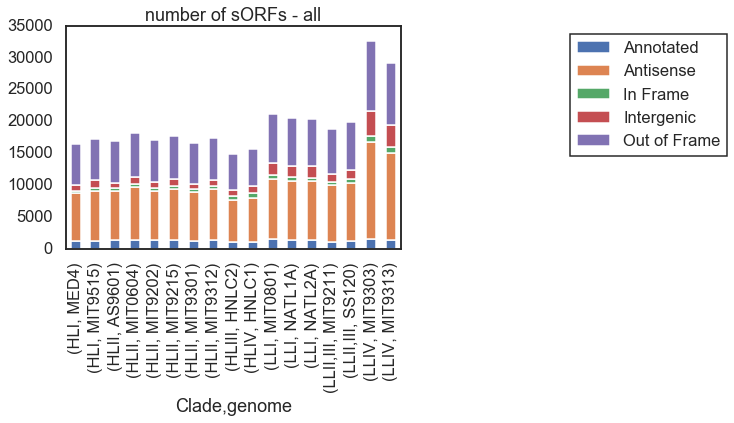

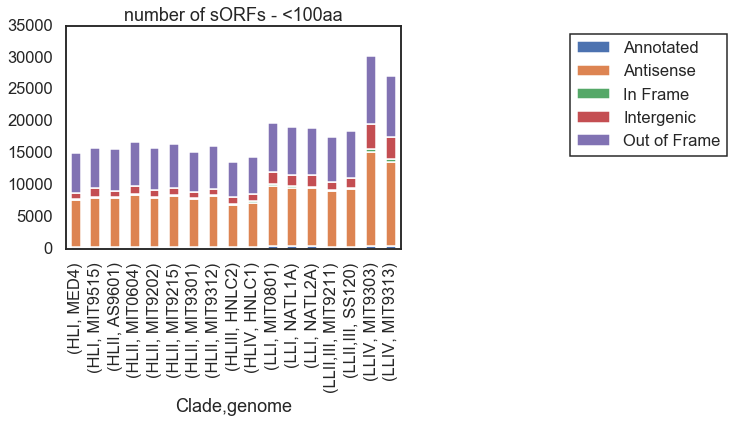

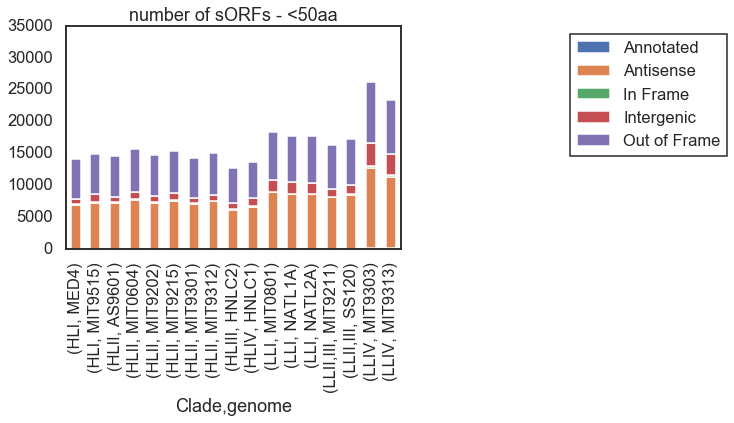

In [35]:
for s in sum_df.subset.unique():
        stacked_df = plot_df(sum_df.loc[(sum_df.subset == s) ], f'number of sORFs - {s}', ylim=(0,35000))
        if s == 'all':
            stacked_df.to_csv('f.csv')

Text(69.033,0.5,'Number of ORFs')

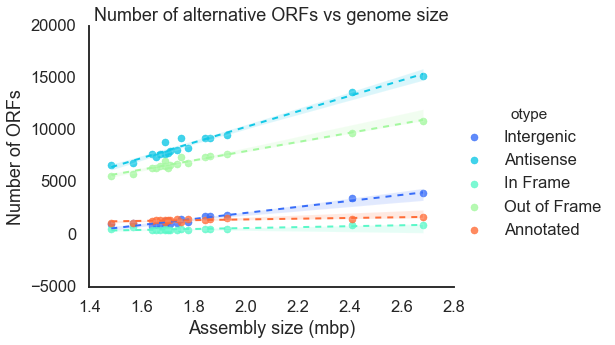

In [55]:
sns.lmplot(data=sum_df.loc[sum_df.subset == 'all'], 
           x=col_bp2, hue='otype', y='count', #row='subset', 
           hue_order=oorder, palette=opalette,
           aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=50),
           line_kws=dict(linewidth=2, linestyle='dashed'),
           truncate=True
          )
plt.title('Number of alternative ORFs vs genome size')
plt.ylabel('Number of ORFs')

#plt.yscale('log')
#plt.xticks(rotation='90') 

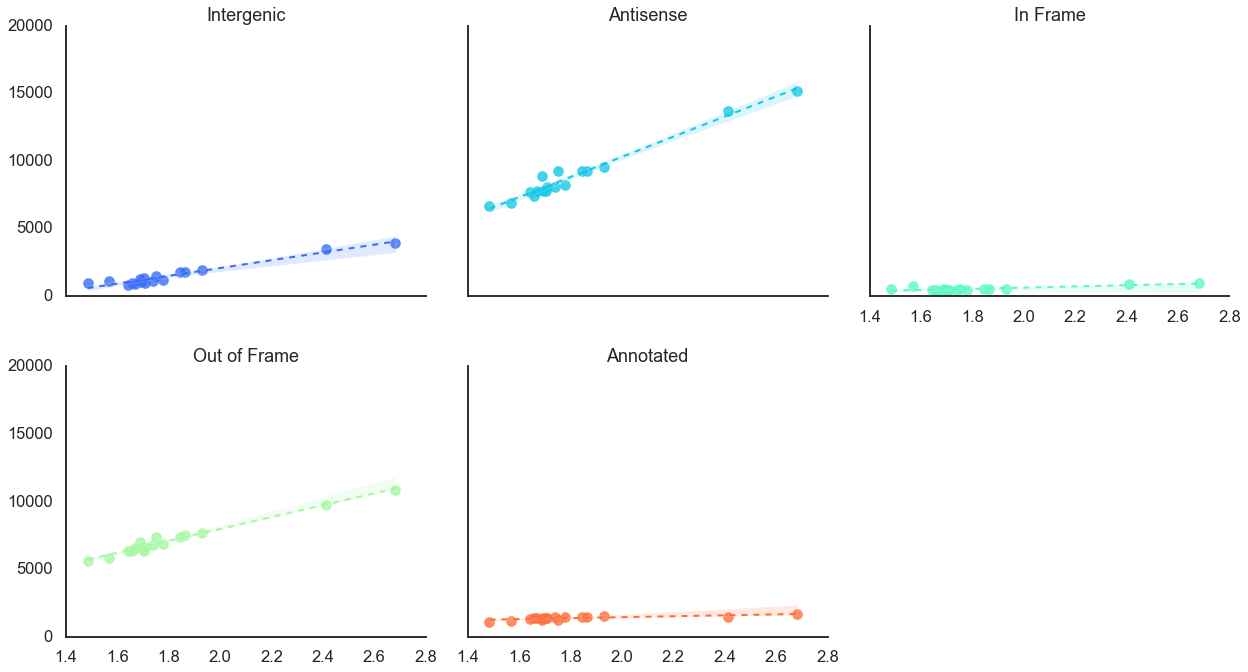

In [38]:

g = sns.lmplot(data=sum_df.loc[sum_df.subset == 'all'], 
           x=col_bp2, col='otype', y='count', #row='subset', 
               col_order=oorder, palette=opalette,
               hue='otype', hue_order=oorder,
           aspect=1.2, #markers=True,
           height=5, col_wrap=3,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=100),
           line_kws=dict(linewidth=2, linestyle='dashed'
                        ),
           truncate=True
          )
g.set_titles("{col_name}")
#plt.yscale('log')
#g.set_major_locator(ticker.MultipleLocator(600000))
#g.set_major_formatter(ticker.ScalarFormatter())
#.set(xticks=range(1200000, 3000000, 600000))
#g.axes.set(xlim=(0,3000000))
#plt.ylim((0,20000))
g.set(ylim=(0, 20000), ylabel='', xlabel='')
#.set_axis_labels("Total bill (US Dollars)", "Tip")
           #xticks=[10, 30, 50], yticks=[2, 6, 10])
      #.fig.subplots_adjust(wspace=.02))

In [17]:
otype_order = [
    'known',
    'standalone',
    'as',
    'as_internal',
    'as_internal_out_frame',
    'as_out_frame',
    'internal_out_frame',
    'downstream_out_frame',
    'downstream_upstream_out_frame',
    'upstream_out_frame',
    'internal',
    'downstream',
    'upstream',
    'overlap_many',
]
otype_palette = ['blue', 'yellow'] + sns.color_palette("Reds", 4).as_hex() + \
    sns.color_palette("Greens", 4).as_hex() + \
    sns.color_palette("Purples", 4).as_hex() 
    

In [18]:
sum_df.head()

,otype,count,subset,genome,Clade,Assembly size (bp),Assembly size (mbp)
0,Antisense,7753,all,AS9601,HLII,1669886,1.669886
1,In Frame,406,all,AS9601,HLII,1669886,1.669886
2,Annotated,1410,all,AS9601,HLII,1669886,1.669886
3,Out of Frame,6596,all,AS9601,HLII,1669886,1.669886
5,Standalone,883,all,AS9601,HLII,1669886,1.669886


In [42]:
sum_dfp = sum_df.pivot_table(index=['otype', 'genome', 'Clade', 'Assembly size (bp)',
       'Assembly size (mbp)'], values='count', columns='subset').reset_index()

In [46]:
sum_dfp['%<50'] = 100* sum_dfp['<50aa'] / sum_dfp['all'] 
sum_dfp['%<100'] = 100 *sum_dfp['<100aa'] / sum_dfp['all'] 
sum_dfp.head()

subset,otype,genome,Clade,Assembly size (bp),Assembly size (mbp),<100aa,<50aa,all,%<50,%<100
0,Annotated,AS9601,HLII,1669886,1.669886,361,98,1410,6.950355,25.602837
1,Annotated,HNLC1,HLIV,1569623,1.569623,351,80,1156,6.920415,30.363322
2,Annotated,HNLC2,HLIII,1484494,1.484494,293,63,1085,5.806452,27.004608
3,Annotated,MED4,HLI,1657990,1.657990,367,99,1370,7.226277,26.788321
4,Annotated,MIT0604,HLII,1780061,1.780061,389,100,1478,6.765900,26.319350


In [49]:
sum_dfp.groupby('otype')[['%<50', '%<100', 'all']].describe().T

otype           Annotated     Antisense    In Frame   Intergenic  Out of Frame
subset                                                                        
%<50   count    17.000000     17.000000   17.000000    17.000000     17.000000
       mean      7.693114     91.289147   20.237001    97.298800     96.804092
       std       2.087150      3.574923    6.703659     1.022206      3.476623
       min       5.727204     81.571637   13.281250    94.840012     87.514107
       25%       6.821480     92.058855   16.105769    96.979332     97.519629
       50%       6.950355     92.454534   17.718447    97.670549     97.758506
       75%       7.731959     92.683585   20.501139    97.951807     98.472816
       max      13.757576     94.195327   39.455782    98.383838     98.665867
%<100  count    17.000000     17.000000   17.000000    17.000000     17.000000
       mean     27.976144     99.143672   38.151944    99.758782     99.675834
       std       3.254313      0.806359    5.889824     0.208975      0.491024
       min      24.157303     96.959064   29.687500    99.365811     98.540522
       25%      25.602837     99.358974   35.214447    99.656062     99.886267
       50%      26.901798     99.414678   36.852207    99.790356     99.927399
       75%      31.454419     99.466170   39.408867    99.910873     99.946092
       max      33.756684     99.569864   55.102041   100.000000     99.961084
all    count    17.000000     17.000000   17.000000    17.000000     17.000000
       mean   1385.000000   8901.882353  541.176471  1530.588235   7155.764706
       std     142.914747   2261.642569  167.388110   887.675902   1332.933397
       min    1085.000000   6654.000000  406.000000   830.000000   5604.000000
       25%    1327.000000   7753.000000  432.000000   990.000000   6355.000000
       50%    1410.000000   8055.000000  512.000000  1163.000000   6783.000000
       75%    1467.000000   9243.000000  555.000000  1769.000000   7420.000000
       max    1650.000000  15198.000000  960.000000  3952.000000  10880.000000

In [50]:
def plot_sorf(genome = 'MED4'):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    sns.catplot(data=df, y='overlap_type', kind='count', aspect=2, height=6,
           order=otype_order, palette=otype_palette)
    #plt.xticks(rotation=90) 
    plt.title(f'number of orfs - {genome}')

    sns.catplot(data=df, y='overlap_type', x='len_aa', aspect=2, height=6,
            kind='box',
           order=otype_order, palette=otype_palette)
    plt.xscale('log')
    plt.title(f'orfs lengths (aa) - {genome}')
    plt.show()
    

In [76]:
def plot_sorf(genome = 'MED4'):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    df = df.loc[df.otype != 'overlap']
    df.otype = df.otype.map(omap)
    
    sns.catplot(data=df, y='otype', kind='count', aspect=1.4, height=4,
           order=oorder, palette=opalette
               )
    plt.xticks(rotation=30) 
    plt.ylabel('ORF Type')
    plt.xlabel('Number of ORFs')
    plt.title(f'Number of ORFs - {genome}')

    sns.catplot(data=df, y='otype', x='len_aa', aspect=1.4, height=4,
            kind='box',
           order=oorder, palette=opalette
               )
    plt.xscale('log')
    plt.ylabel('ORF Type')
    plt.xlabel('ORFs length (aa)')
    
    plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
    plt.show()
    

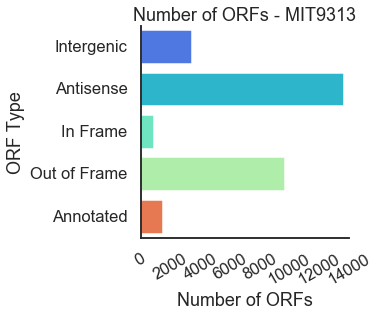

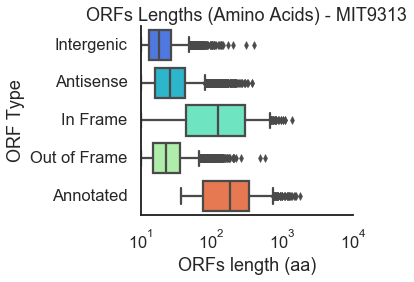

In [77]:
plot_sorf('MIT9313')

C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


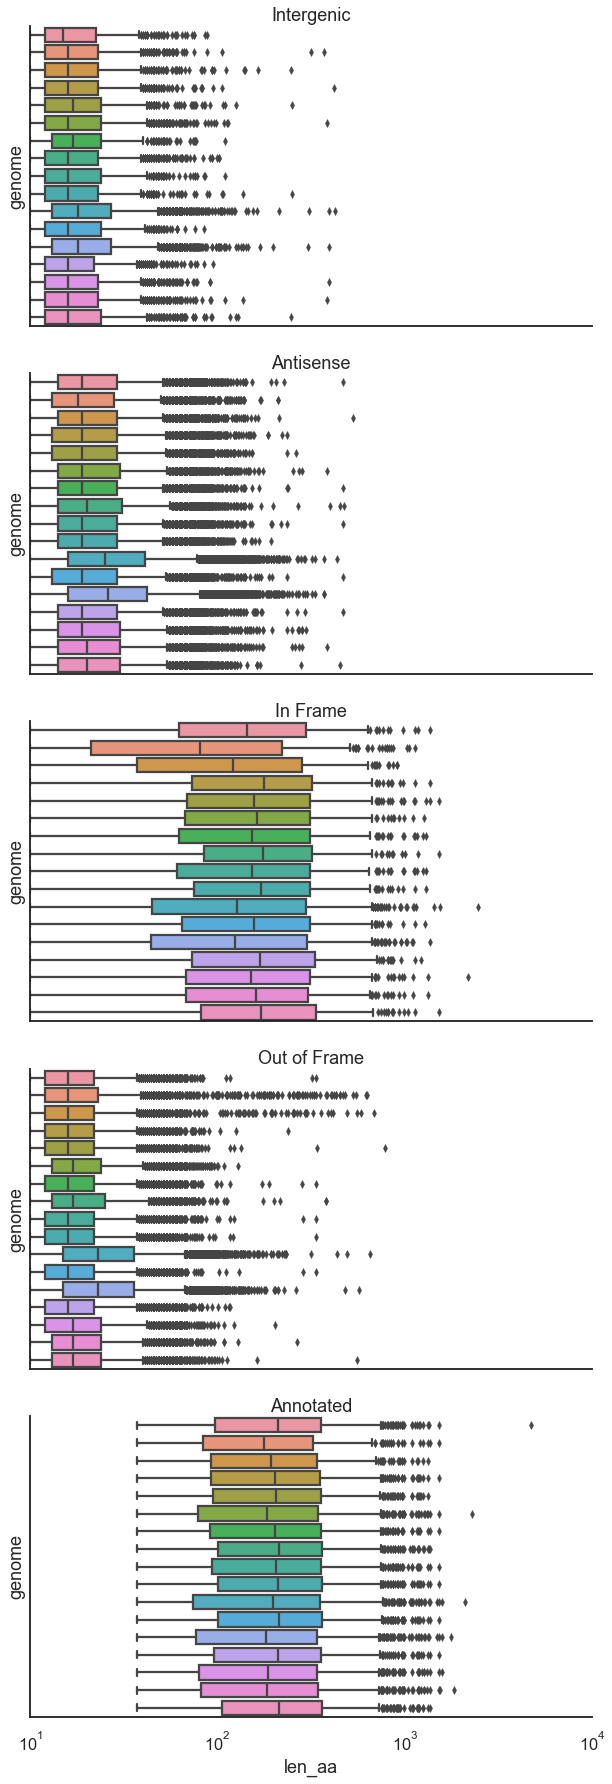

In [52]:
def _read(genome):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    df['genome'] = genome
    return df
#df_list = [pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
df_list = [_read(genome) for genome in sum_df.genome.unique()]
df = pd.concat(df_list)
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)



g = sns.catplot(data=df, row='otype', x='len_aa', aspect=2, height=5,
            kind='box', y='genome', #hue='otype', #hue_order=oorder,
           row_order=oorder, #palette=opalette
               )
g.set(yticks=[])
g.set_titles("{row_name}")

plt.xscale('log')
#plt.title(f'orfs lengths (aa) ')
plt.show()
    

In [53]:
df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,is_inside,is_out_of_frame,is_same_strand,is_upstream,otype,overlap_count,overlap_gene_type,overlap_location,overlap_strand,overlap_type
0,ORF1_jcventer:AS9601:345:404,jcventer:AS9601,345,404,345,404,+,MELSKIVELSLYPQNFYQK,60,19,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
1,ORF2_jcventer:AS9601:516:560,jcventer:AS9601,516,560,516,560,+,MNILICHLLKAVLL,45,14,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
2,ORF3_jcventer:AS9601:618:677,jcventer:AS9601,618,677,618,677,+,MMIQSNYSQVSILLSNQII,60,19,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
3,ORF4_jcventer:AS9601:1098:1178,jcventer:AS9601,1098,1178,1098,1178,+,MLKILEMQMNQYLFLIQEKILILHLM,81,26,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
4,ORF5_jcventer:AS9601:1386:2033,jcventer:AS9601,1386,2033,1386,2033,+,MVLNYGNGENVWMHPPVHRILGWYSRPSNFDLKRNVWRLNQITQII...,648,215,...,1.0,0.0,1.0,0.0,In Frame,1,peg,AS9601_1327_2034,+,internal


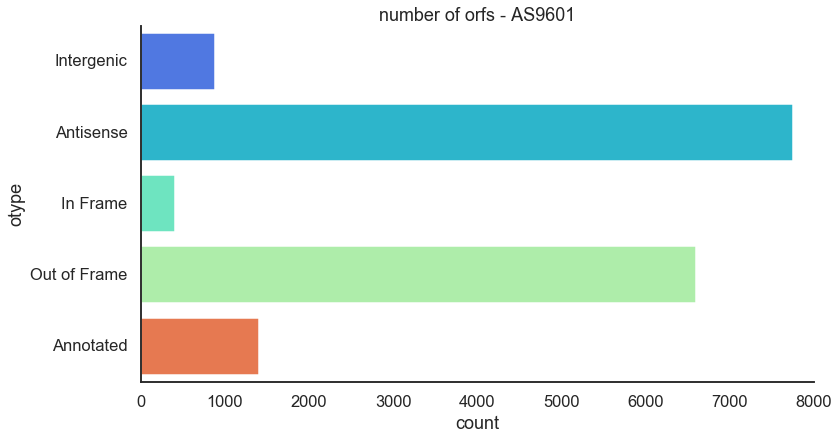

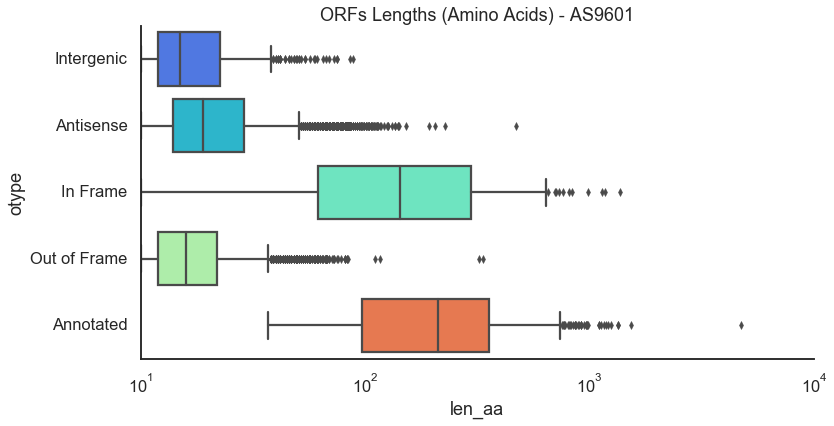

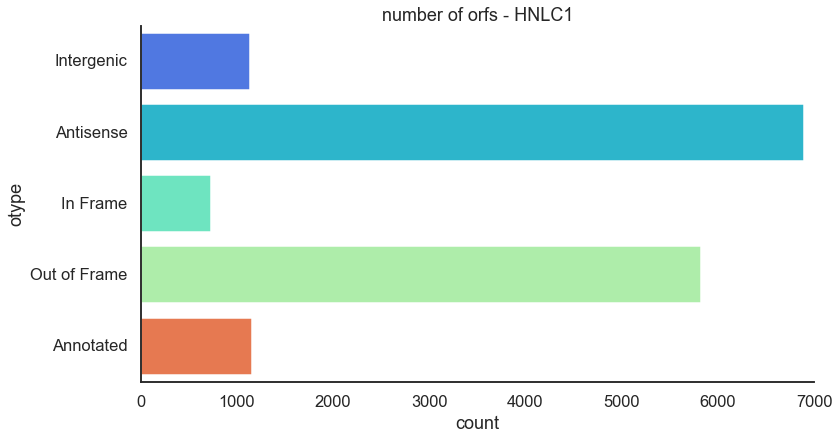

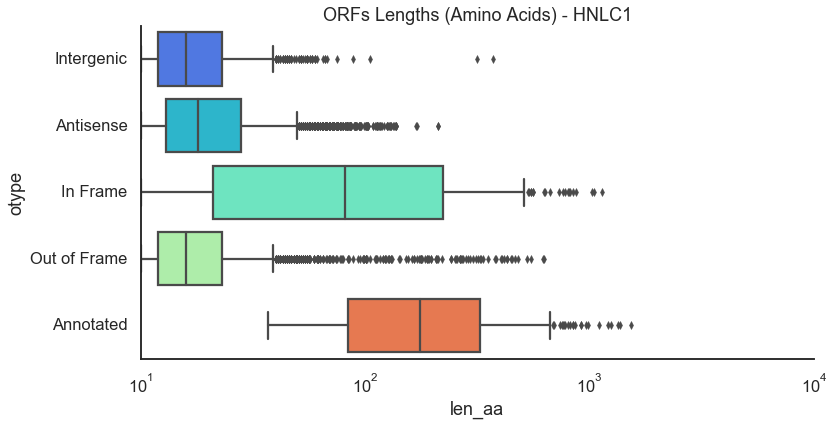

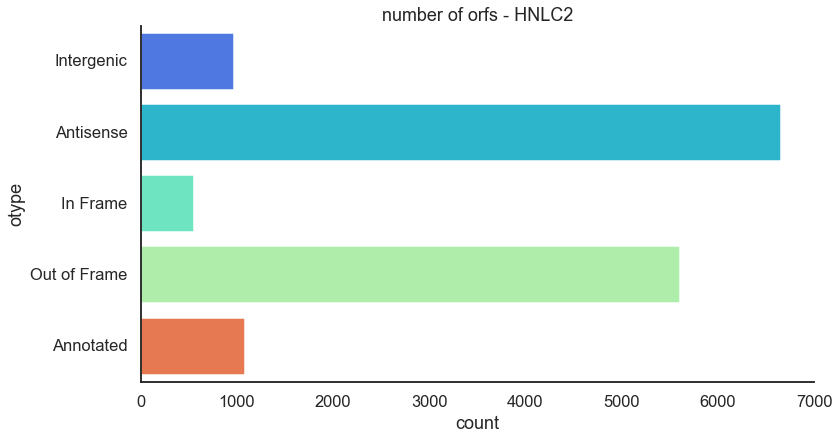

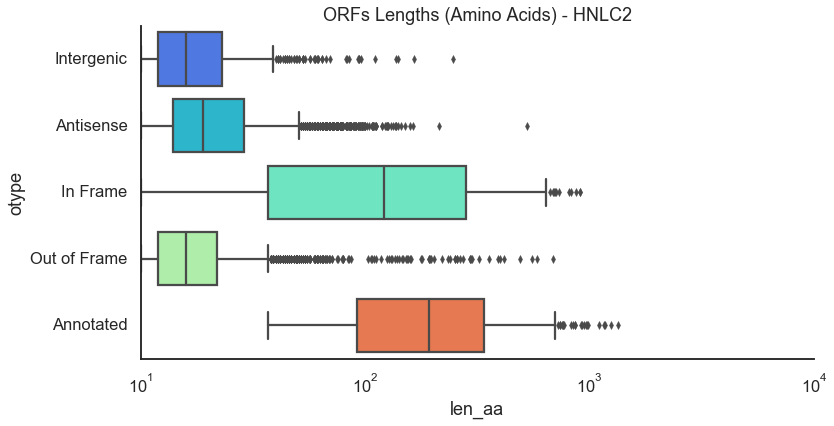

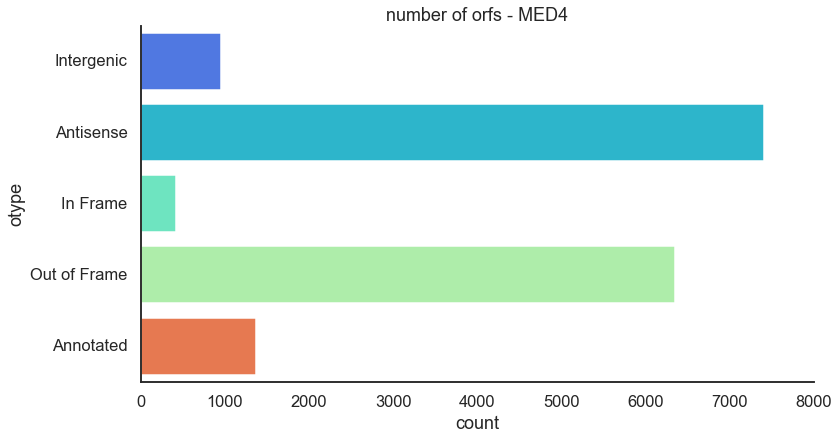

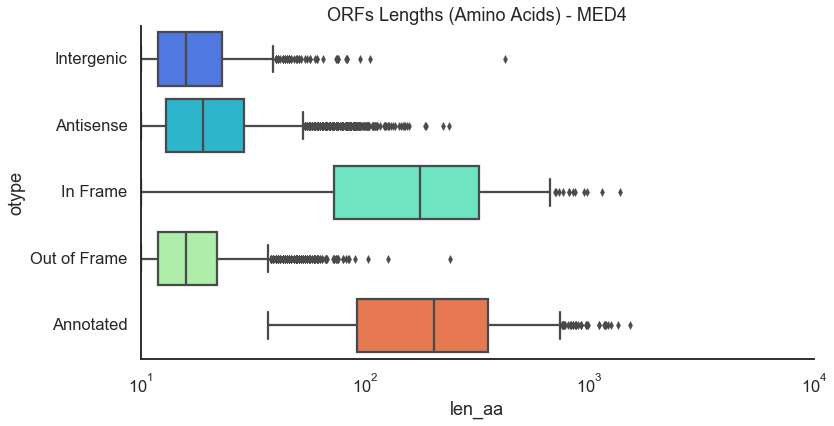

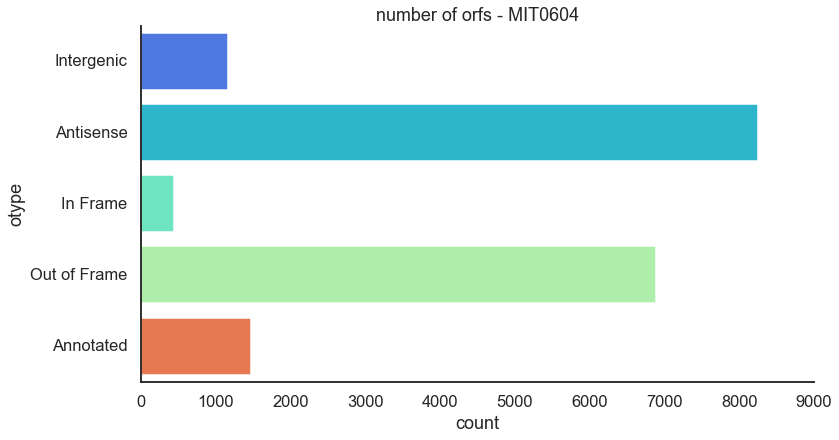

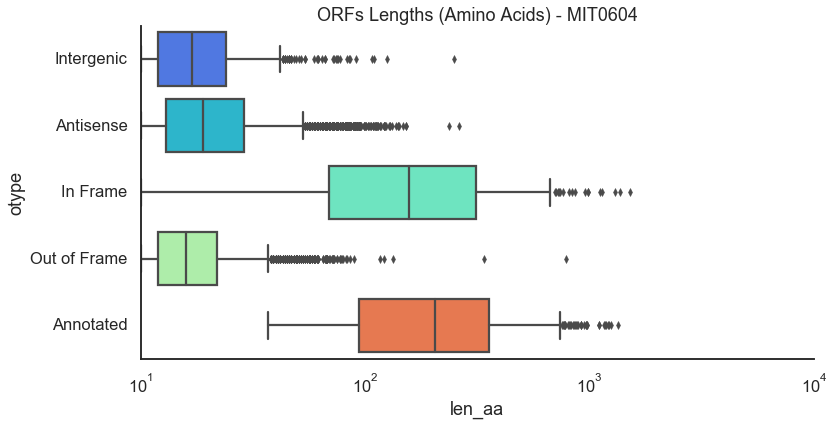

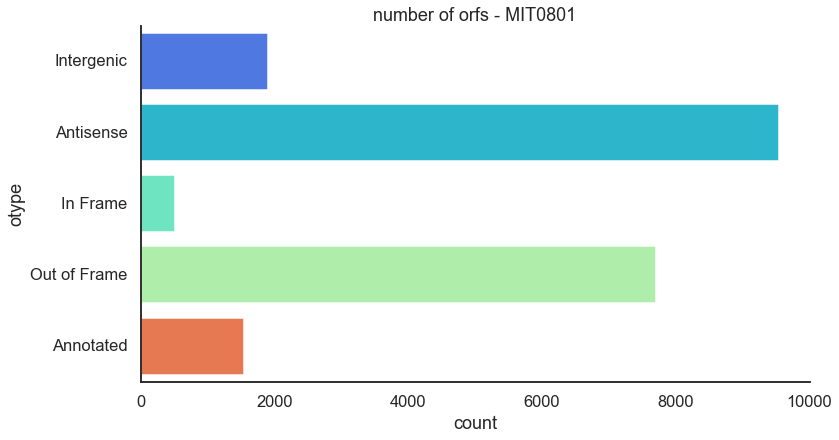

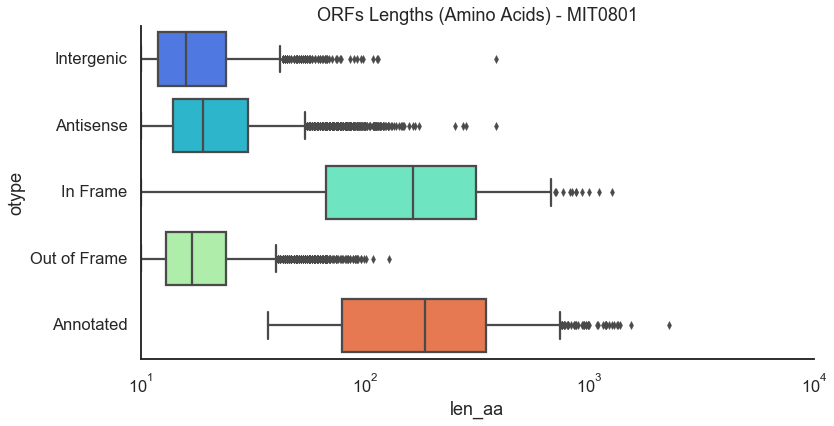

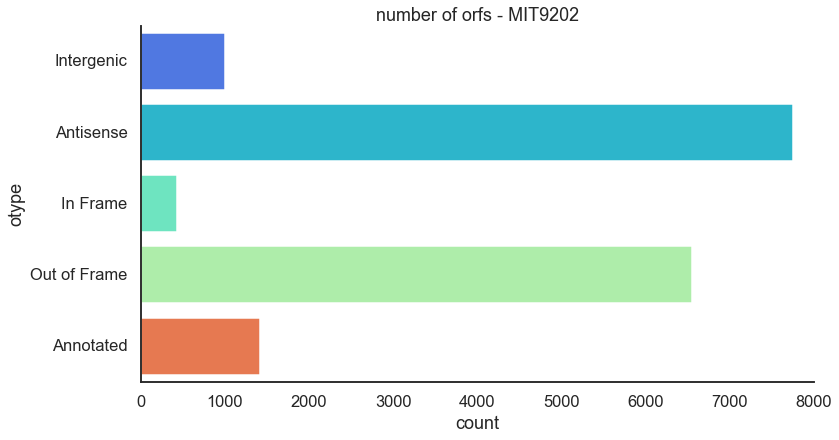

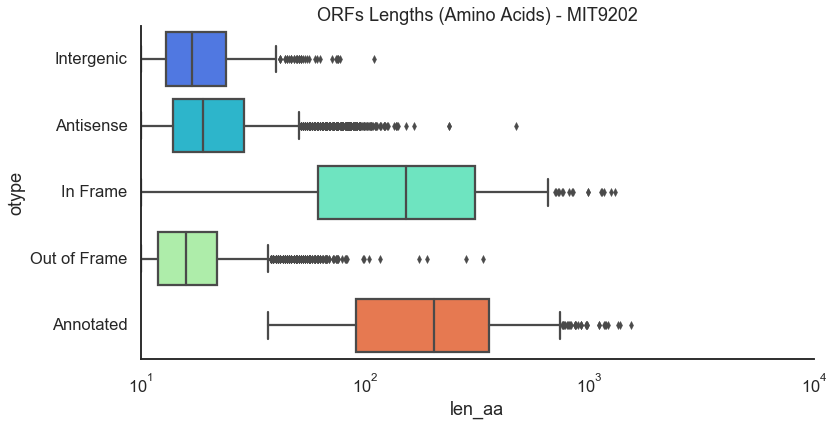

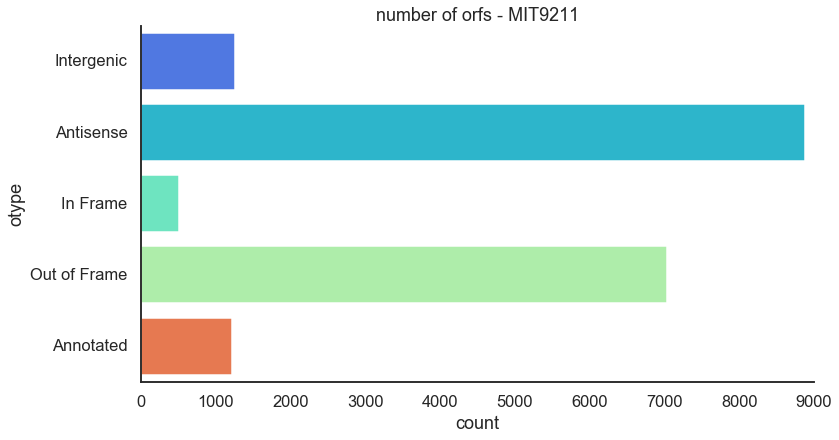

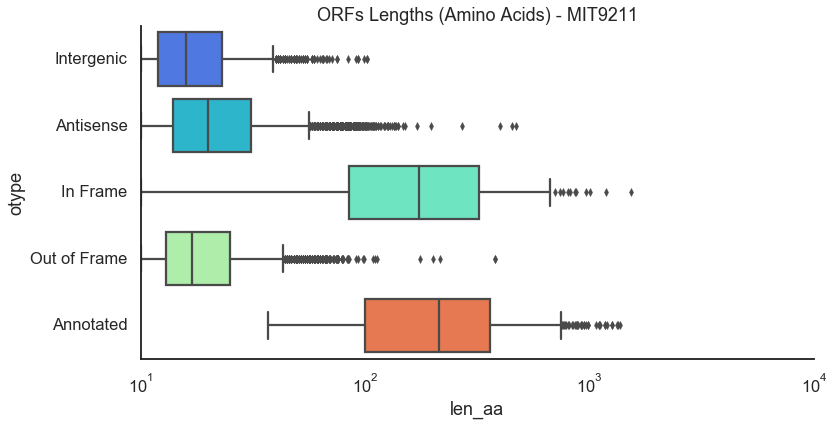

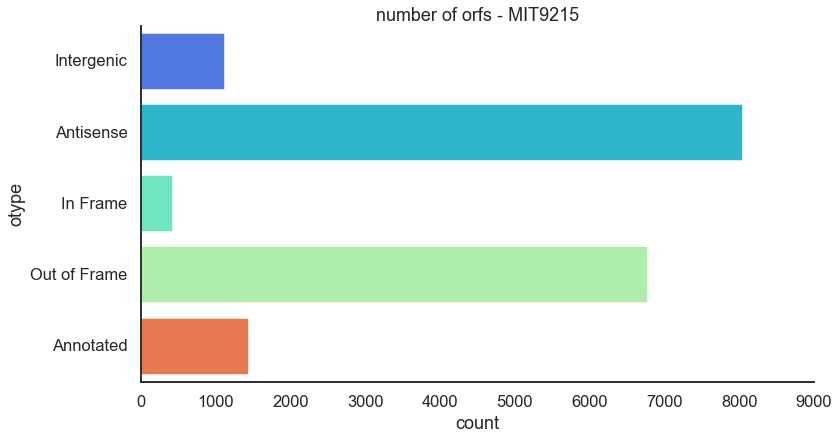

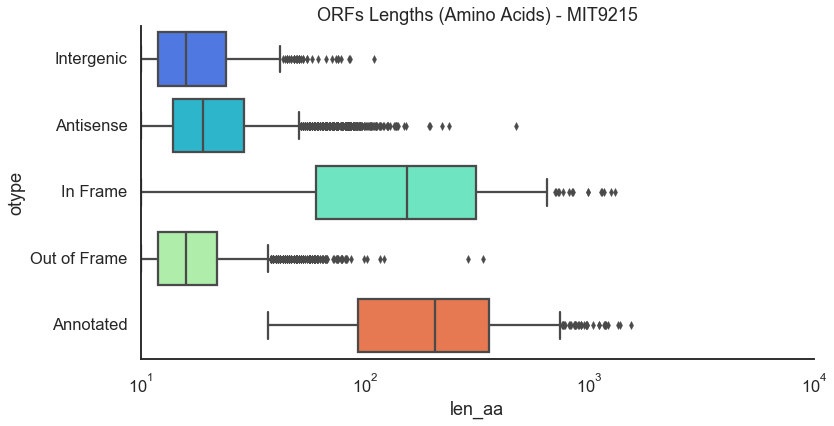

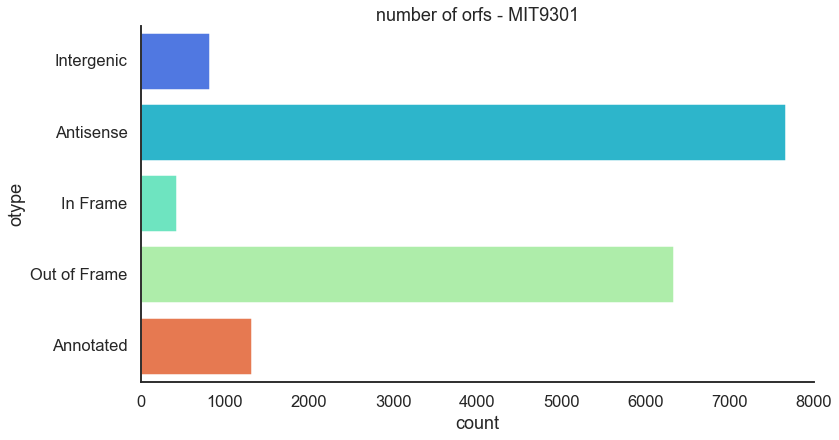

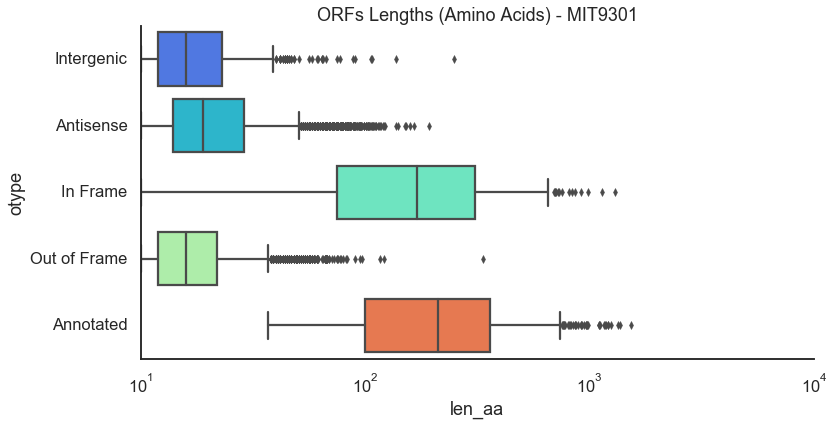

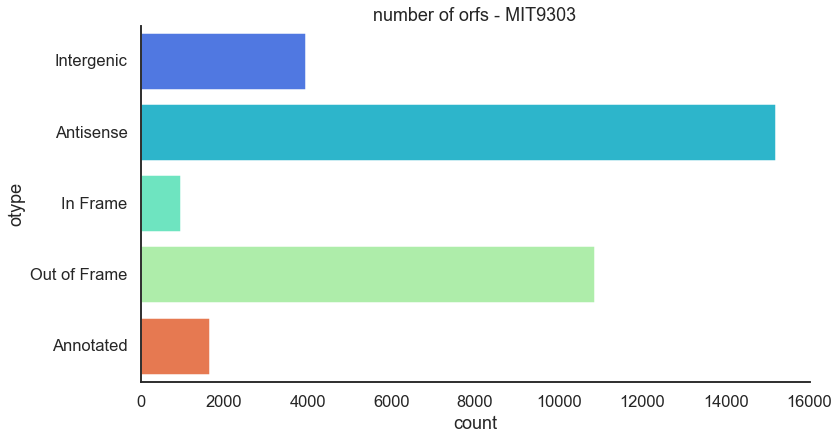

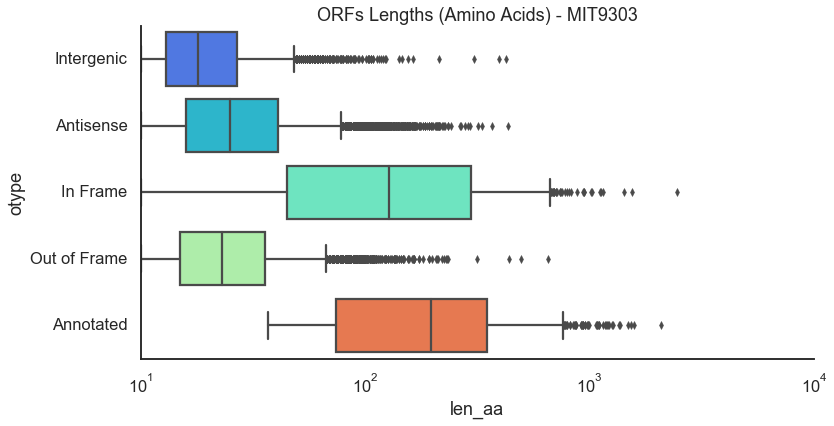

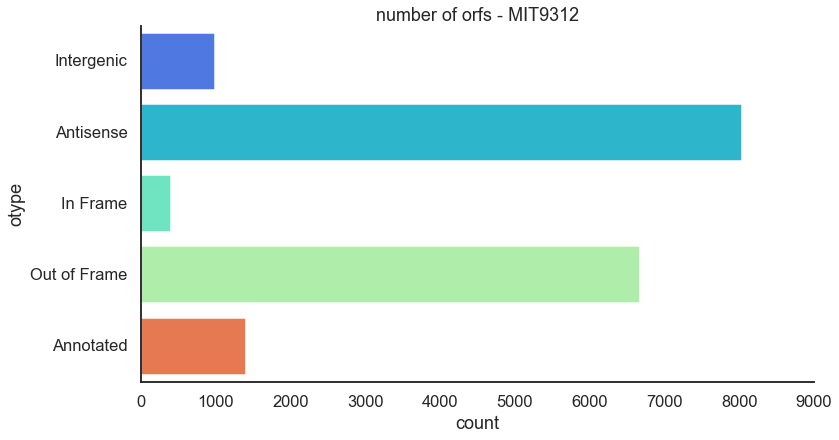

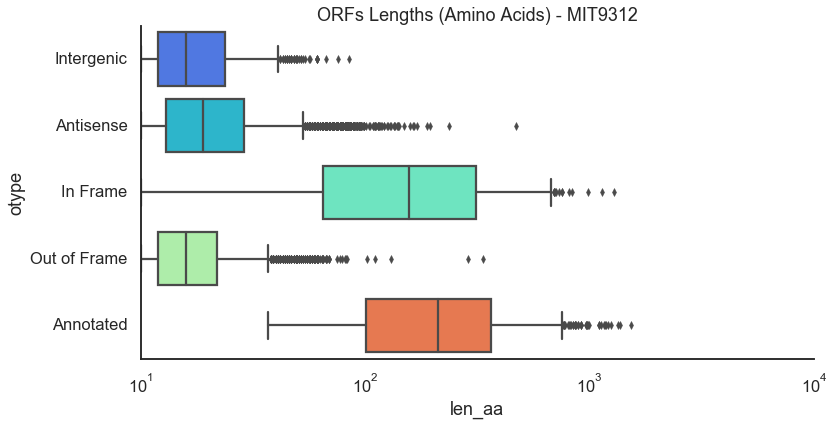

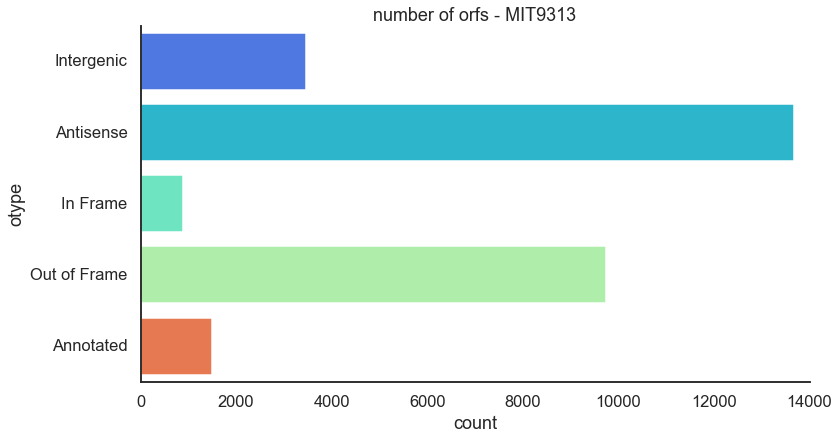

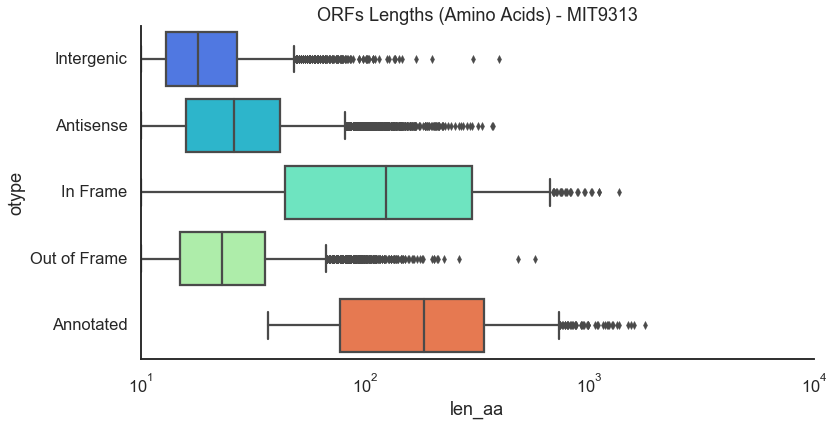

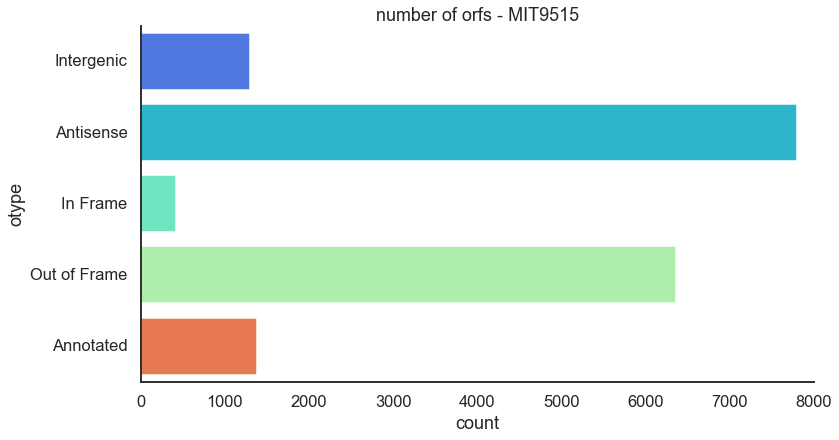

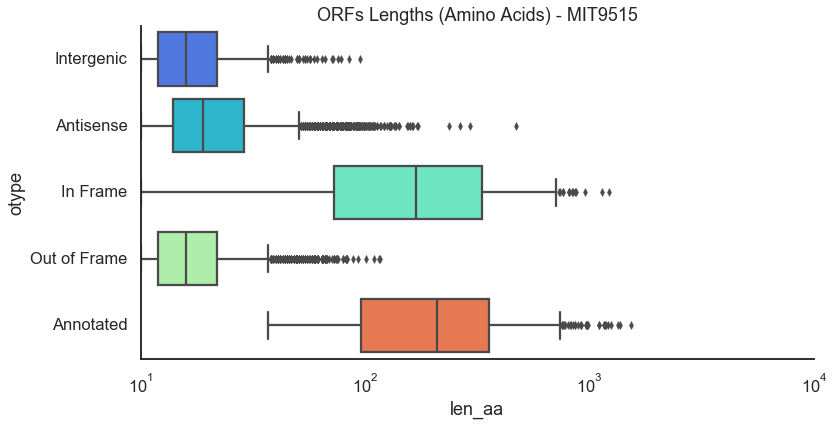

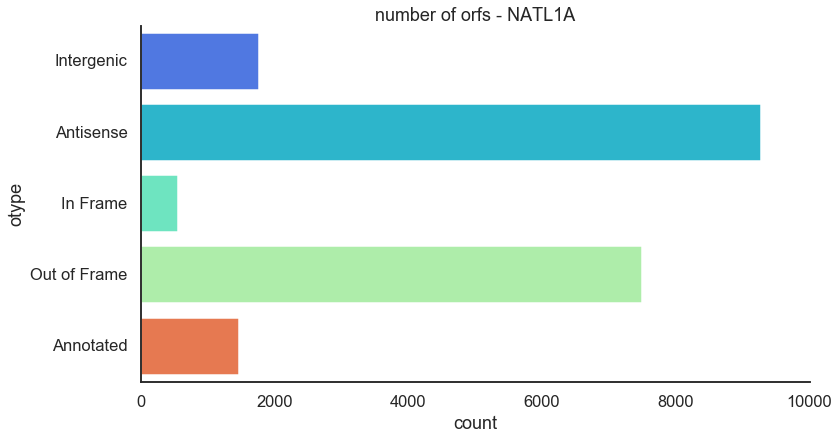

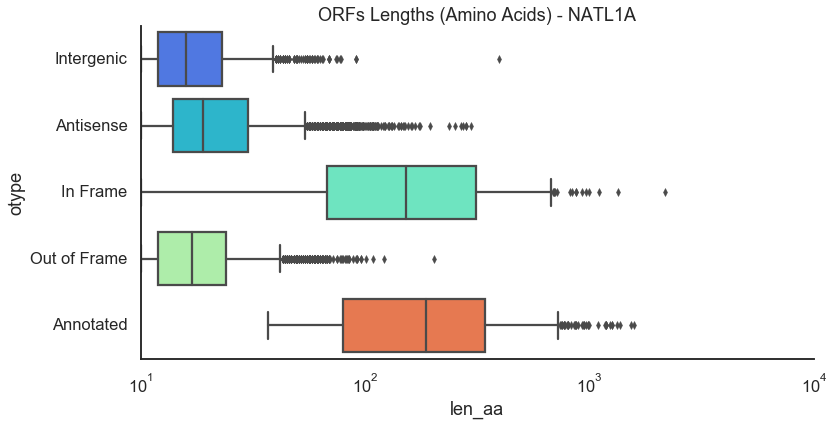

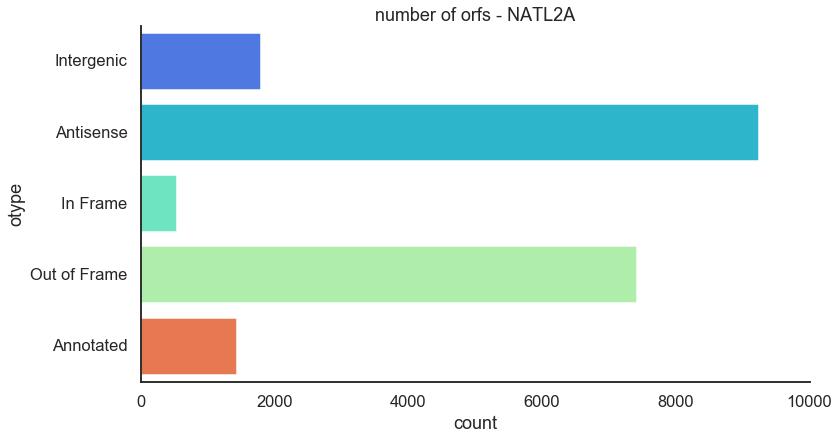

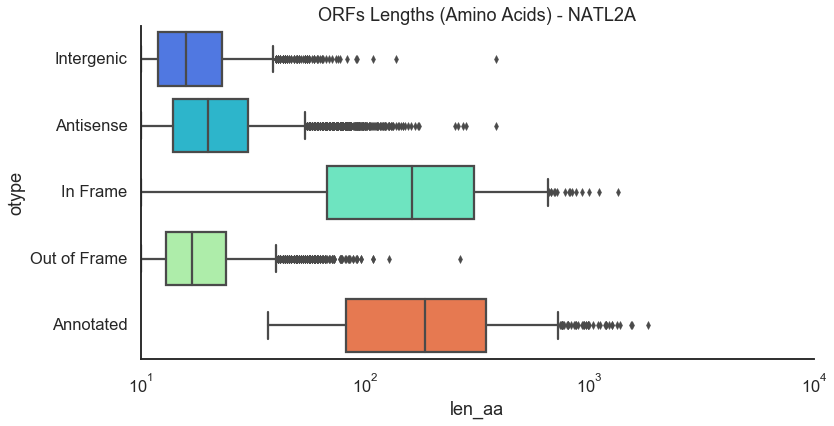

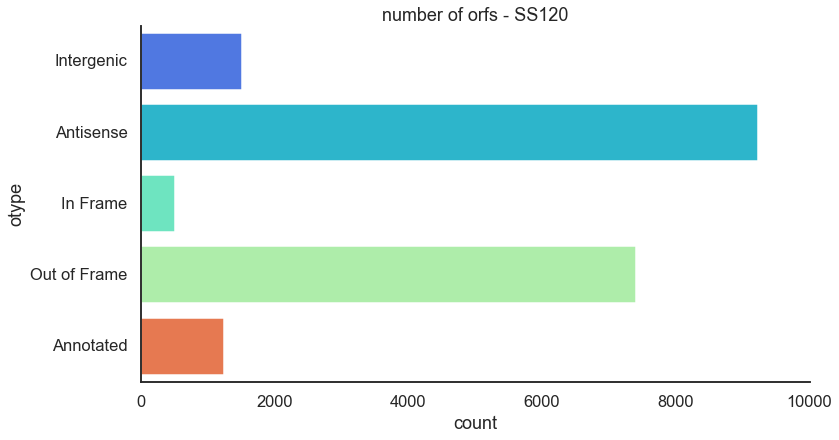

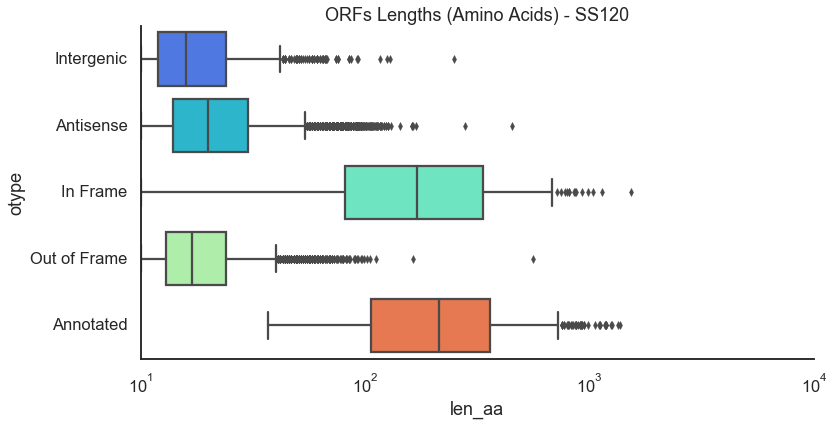

In [54]:
for i in sum_df.genome.unique():
    plot_sorf(i)